# Tree Based Models

In this notebook, we will model the relation between weather data and adjusted bike trips using decision tree regression model, as well as boosting algorithm based on decision trees.

Previously, we were assuming our model takes the form $T(t) + f(X)$, where $T(t)$ is the trend, $f(X)$ is the seasonality caused by weather data.
However, since the magnitude of the seasonality seems to increase over time, it may make sense to assume a multiplicative model $T(t)*f(X)$.

In this alternative version of tree model notebook, we will de-trend data according to this multiplicative model. Specifically, we set 'adj_num_trips' as our de-trended data, which is equal to 'num_trip'/'trend'. After we make prediction of 'adj_num_trips', we multiply it by 'trend' to recover the trended prediction. Then we compute rmse based on trended prediction and compare models.

## Import Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_style('whitegrid')

In [4]:
# import training data
bike_train = pd.read_csv('../EDA/bikeshare_train_data_pcwsdetrend_mult.csv', parse_dates=['Date'])

In [5]:
# Keith's file already included detrended data
# bike_train['adj_num_trips'] = bike_train['num_trips']/bike_train['trend']

'adj_num_trips' is our de-trended data. We will make our predictions of 'adj_num_trips' and then multiply the prediction by 'trend' to recover the trended prediction.

In [7]:

bike_test = pd.read_csv('../EDA/bikeshare_test_data_pcwsdetrend_mult.csv', parse_dates=['Date'])

In [11]:
# if using Keith's detrend data, rename trend_val to trend
bike_train.rename(columns={'trend_val':'trend'}, inplace=True)

In [12]:
bike_test.rename(columns={'trend_val':'trend'}, inplace=True)

In [13]:
# bike_test['adj_num_trips'] = bike_test['num_trips']/bike_test['trend']

Below we explain the meaning of our data.

In [43]:
bike_train.head()

,Date,day_length,min_temp,max_temp,mean_temp,temp_diff,hdd,cdd,rain,snow,...,max_gust,mean_dep_temp,mean_ret_temp,mean_ride_temp,total_dist,total_duration,ebike_trips,num_trips,adj_num_trips,trend
0,2017-01-01,497.133333,-2.3,2.2,-0.1,4.5,18.1,0.0,0.0,0.0,...,10.0,3.555556,4.296296,3.925926,338025.0,232693.0,0.0,162,152.672085,1.061098
1,2017-01-02,498.133333,-6.0,1.4,-2.3,7.4,20.3,0.0,0.0,0.0,...,0.0,2.718519,3.688889,3.203704,660054.0,382729.0,0.0,270,254.394287,1.061345
2,2017-01-03,499.133333,-7.8,0.4,-3.7,8.2,21.7,0.0,0.0,0.0,...,0.0,0.807292,1.791667,1.299479,635395.0,376013.0,0.0,384,361.721069,1.061591
3,2017-01-04,501.133333,-8.4,2.2,-3.1,10.6,21.1,0.0,0.0,0.0,...,1.0,2.767391,3.643478,3.205435,766082.0,376721.0,0.0,460,433.210952,1.061838
4,2017-01-05,502.133333,-6.6,0.7,-3.0,7.3,21.0,0.0,0.0,0.0,...,0.0,2.601145,3.524809,3.062977,888222.0,524933.0,0.0,524,493.369072,1.062085


Recall that the features are defined as:

- ``day_length``: The number of minutes from sunrise to sunset for the given day
- ``min_temp``: The daily minimum temperature (deg C)
- ``max_temp``: The daily maximum temperature (deg C)
- ``mean_temp``: The mean temperature of the day (deg C)
- ``temp_diff``: The difference between the daily minimum and maximum temperatures (deg C)
- ``hdd``: The "Heating Degree Days" of the day, the number of degrees C that the daily average temperature is below 18 degrees C (0 if the daily average temperature is above 18 degrees C)
- ``cdd``: The "Cooling Degree Days" of the day, the number of degrees C that the daily average temperature is above 18 degrees C (0 if the daily average temperature is below 18 degrees C)
- ``rain``: The amount of rain that occurred that day (mm)
- ``snow``: The amount of snow that occurred that day (cm)
- ``total_precip``: The total amount of rain and snow that occurred that day (mm) (Note: the standard conversion of snow-to-rain amount is a factor of ten, so 1cm of snow is equivalent to 1mm of rain; therefore, this column is exactly the sum of ``rain`` and ``snow``)
- ``snow_on_ground``: The amount of snow observed on the ground during the day (cm)
- ``max_gust``: The difference between the speed of the observed maximum gust of wind (in km/hr) and 31 km/hr (0 if the maximum observed gust of wind is at or below 31 km/hr)
- ``mean_dep_temp``: The mean departure temperature of all bike rides taken that day (deg C)
- ``mean_ret_temp``: The mean return temperature of all bike rides taken that day (deg C)
- ``total_dist``: The total distance covered by all bike rides taken that day (m)
- ``total_duration``: The total time spent on bikes that day (sec)
- ``ebike_trips``: The number of bike rides taken on electric bikes that day
- ``num_trips`` The total number of bike rides taken that day, regardless of bicycle type
- In the notebook ``EDA.ipynb`` we added another column, ``adj_num_trips``, that are the number of trips with a certain baseline bikeshare demand removed. Depending on the file loaded in above, ``adj_num_trips`` is some adjusted number of bike rides for a particular de-trending. (If there are any additional columns, they are for predicting ``num_trips`` from ``adj_num_trips`` once predicted.)

We will first predict the value of adj_num_trips using weather data, and then later convert the result into predictions of ``num_trips`` by multiplying it with trend.

Below is a plot of detrended data using multiplicative model.

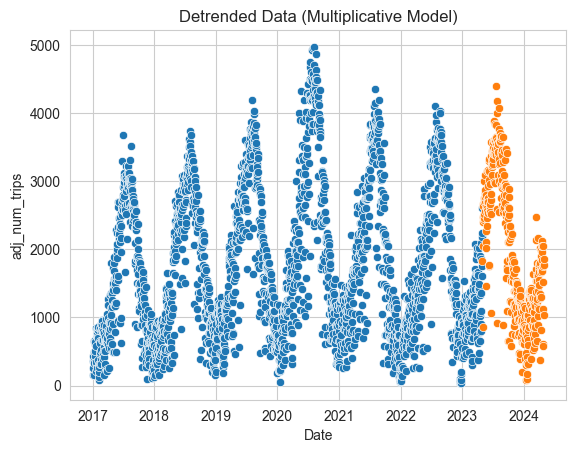

In [14]:
sns.scatterplot(x=bike_train['Date'], y=bike_train['adj_num_trips'])
sns.scatterplot(x=bike_test['Date'], y=bike_test['adj_num_trips'])
plt.title('Detrended Data (Multiplicative Model)')
plt.show()

## Decision Tree Regressor

We first build a decision tree regressor with feature set chosen from 'max_temp', 'hdd', 'total_precip'. These features are selected based on previous EDA.

In [15]:
features = ['max_temp', 'total_precip', 'day_length', 'snow_on_ground', 'max_gust']

In [16]:
# define powerset function to return all subset of a list

from itertools import chain, combinations

def powerset(iterable):
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

In [17]:
from sklearn.tree import DecisionTreeRegressor

In [18]:
from sklearn.metrics import mean_squared_error

In [19]:
MAX_DEPTH = 10

In [20]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5, random_state=16, shuffle=True)

In [21]:
mses_train = np.zeros((5,2**len(features)-1,MAX_DEPTH))
mses_val = np.zeros((5,2**len(features)-1,MAX_DEPTH))
# the first component refers to validation number, the second component refers to the feature used, 
# the third refers to the max_depth of the tree

In [22]:
cv_count = 0

for train_index, test_index in kfold.split(bike_train):
    feature_count = 0
    cv_train = bike_train.iloc[train_index]
    cv_val = bike_train.iloc[test_index]
    for feature in powerset(features):
        feature = list(feature)
        if len(feature) > 0:
            print('feature_count is ', feature_count)
            for max_depth in range(1,MAX_DEPTH+1):
                print(f'Fitting tree model with features {feature} and max depth {max_depth}')
                tree = DecisionTreeRegressor(max_depth = max_depth)
                tree.fit(cv_train[feature],cv_train['adj_num_trips'])
        
                # predict
                pred_train = tree.predict(cv_train[feature])
                pred_val = tree.predict(cv_val[feature])
                
                # compute mse and store
                mse_train = np.sqrt(mean_squared_error(cv_train['num_trips'], pred_train*cv_train['trend']))
                mse_val = np.sqrt(mean_squared_error(cv_val['num_trips'], pred_val*cv_val['trend']))
                mses_train[cv_count,feature_count,max_depth-1] = mse_train
                mses_val[cv_count,feature_count,max_depth-1] = mse_val
                
                # plot the in-sample and out-of-sample prediction with true values
#                 fig, ax = plt.subplots(1,2,figsize = (12,5))
#                 sns.scatterplot(x=bike_train['time'], y=bike_train['adj_num_trips'], ax=ax[0], color='blue', alpha=0.5)
#                 sns.scatterplot(x=bike_train['time'], y=pred_train, ax=ax[0], color='orange')
            
#                 sns.scatterplot(x=bike_test['time'], y=bike_test['adj_num_trips'], ax=ax[1], color='blue', alpha=0.5)
#                 sns.scatterplot(x=bike_test['time'], y=pred_test, ax=ax[1], color='orange') 
            
#                 plt.show()
            
                # plot the residue plot
            
#                 if len(feature) == 1:
                
#                     fig, ax = plt.subplots(1,2,figsize = (12,5))
#                     sns.scatterplot(x=bike_train[feature[0]], y=bike_train['adj_num_trips'] - pred_train, ax=ax[0], color='green')
#                     sns.scatterplot(x=bike_test[feature[0]], y=bike_test['adj_num_trips'] - pred_test, ax=ax[1], color='green')
#                     ax[0].set_title(f'Residue plot of adj_num_trips against {feature[0]} in training data')
#                     ax[1].set_title(f'Residue plot of adj_num_trips against {feature[0]} in testing data')
                
#                     plt.show()
            feature_count += 1
    cv_count += 1

feature_count is  0
Fitting tree model with features ['max_temp'] and max depth 1
Fitting tree model with features ['max_temp'] and max depth 2
Fitting tree model with features ['max_temp'] and max depth 3
Fitting tree model with features ['max_temp'] and max depth 4
Fitting tree model with features ['max_temp'] and max depth 5
Fitting tree model with features ['max_temp'] and max depth 6
Fitting tree model with features ['max_temp'] and max depth 7
Fitting tree model with features ['max_temp'] and max depth 8
Fitting tree model with features ['max_temp'] and max depth 9
Fitting tree model with features ['max_temp'] and max depth 10
feature_count is  1
Fitting tree model with features ['total_precip'] and max depth 1
Fitting tree model with features ['total_precip'] and max depth 2
Fitting tree model with features ['total_precip'] and max depth 3
Fitting tree model with features ['total_precip'] and max depth 4
Fitting tree model with features ['total_precip'] and max depth 5
Fitting t

Fitting tree model with features ['total_precip', 'day_length', 'snow_on_ground'] and max depth 9
Fitting tree model with features ['total_precip', 'day_length', 'snow_on_ground'] and max depth 10
feature_count is  22
Fitting tree model with features ['total_precip', 'day_length', 'max_gust'] and max depth 1
Fitting tree model with features ['total_precip', 'day_length', 'max_gust'] and max depth 2
Fitting tree model with features ['total_precip', 'day_length', 'max_gust'] and max depth 3
Fitting tree model with features ['total_precip', 'day_length', 'max_gust'] and max depth 4
Fitting tree model with features ['total_precip', 'day_length', 'max_gust'] and max depth 5
Fitting tree model with features ['total_precip', 'day_length', 'max_gust'] and max depth 6
Fitting tree model with features ['total_precip', 'day_length', 'max_gust'] and max depth 7
Fitting tree model with features ['total_precip', 'day_length', 'max_gust'] and max depth 8
Fitting tree model with features ['total_preci

feature_count is  0
Fitting tree model with features ['max_temp'] and max depth 1
Fitting tree model with features ['max_temp'] and max depth 2
Fitting tree model with features ['max_temp'] and max depth 3
Fitting tree model with features ['max_temp'] and max depth 4
Fitting tree model with features ['max_temp'] and max depth 5
Fitting tree model with features ['max_temp'] and max depth 6
Fitting tree model with features ['max_temp'] and max depth 7
Fitting tree model with features ['max_temp'] and max depth 8
Fitting tree model with features ['max_temp'] and max depth 9
Fitting tree model with features ['max_temp'] and max depth 10
feature_count is  1
Fitting tree model with features ['total_precip'] and max depth 1
Fitting tree model with features ['total_precip'] and max depth 2
Fitting tree model with features ['total_precip'] and max depth 3
Fitting tree model with features ['total_precip'] and max depth 4
Fitting tree model with features ['total_precip'] and max depth 5
Fitting t

Fitting tree model with features ['day_length', 'max_gust'] and max depth 2
Fitting tree model with features ['day_length', 'max_gust'] and max depth 3
Fitting tree model with features ['day_length', 'max_gust'] and max depth 4
Fitting tree model with features ['day_length', 'max_gust'] and max depth 5
Fitting tree model with features ['day_length', 'max_gust'] and max depth 6
Fitting tree model with features ['day_length', 'max_gust'] and max depth 7
Fitting tree model with features ['day_length', 'max_gust'] and max depth 8
Fitting tree model with features ['day_length', 'max_gust'] and max depth 9
Fitting tree model with features ['day_length', 'max_gust'] and max depth 10
feature_count is  14
Fitting tree model with features ['snow_on_ground', 'max_gust'] and max depth 1
Fitting tree model with features ['snow_on_ground', 'max_gust'] and max depth 2
Fitting tree model with features ['snow_on_ground', 'max_gust'] and max depth 3
Fitting tree model with features ['snow_on_ground', 'm

Fitting tree model with features ['total_precip', 'snow_on_ground', 'max_gust'] and max depth 7
Fitting tree model with features ['total_precip', 'snow_on_ground', 'max_gust'] and max depth 8
Fitting tree model with features ['total_precip', 'snow_on_ground', 'max_gust'] and max depth 9
Fitting tree model with features ['total_precip', 'snow_on_ground', 'max_gust'] and max depth 10
feature_count is  24
Fitting tree model with features ['day_length', 'snow_on_ground', 'max_gust'] and max depth 1
Fitting tree model with features ['day_length', 'snow_on_ground', 'max_gust'] and max depth 2
Fitting tree model with features ['day_length', 'snow_on_ground', 'max_gust'] and max depth 3
Fitting tree model with features ['day_length', 'snow_on_ground', 'max_gust'] and max depth 4
Fitting tree model with features ['day_length', 'snow_on_ground', 'max_gust'] and max depth 5
Fitting tree model with features ['day_length', 'snow_on_ground', 'max_gust'] and max depth 6
Fitting tree model with featur

Fitting tree model with features ['day_length'] and max depth 7
Fitting tree model with features ['day_length'] and max depth 8
Fitting tree model with features ['day_length'] and max depth 9
Fitting tree model with features ['day_length'] and max depth 10
feature_count is  3
Fitting tree model with features ['snow_on_ground'] and max depth 1
Fitting tree model with features ['snow_on_ground'] and max depth 2
Fitting tree model with features ['snow_on_ground'] and max depth 3
Fitting tree model with features ['snow_on_ground'] and max depth 4
Fitting tree model with features ['snow_on_ground'] and max depth 5
Fitting tree model with features ['snow_on_ground'] and max depth 6
Fitting tree model with features ['snow_on_ground'] and max depth 7
Fitting tree model with features ['snow_on_ground'] and max depth 8
Fitting tree model with features ['snow_on_ground'] and max depth 9
Fitting tree model with features ['snow_on_ground'] and max depth 10
feature_count is  4
Fitting tree model wit

Fitting tree model with features ['max_temp', 'total_precip', 'day_length'] and max depth 5
Fitting tree model with features ['max_temp', 'total_precip', 'day_length'] and max depth 6
Fitting tree model with features ['max_temp', 'total_precip', 'day_length'] and max depth 7
Fitting tree model with features ['max_temp', 'total_precip', 'day_length'] and max depth 8
Fitting tree model with features ['max_temp', 'total_precip', 'day_length'] and max depth 9
Fitting tree model with features ['max_temp', 'total_precip', 'day_length'] and max depth 10
feature_count is  16
Fitting tree model with features ['max_temp', 'total_precip', 'snow_on_ground'] and max depth 1
Fitting tree model with features ['max_temp', 'total_precip', 'snow_on_ground'] and max depth 2
Fitting tree model with features ['max_temp', 'total_precip', 'snow_on_ground'] and max depth 3
Fitting tree model with features ['max_temp', 'total_precip', 'snow_on_ground'] and max depth 4
Fitting tree model with features ['max_tem

Fitting tree model with features ['max_temp', 'total_precip', 'day_length', 'snow_on_ground'] and max depth 7
Fitting tree model with features ['max_temp', 'total_precip', 'day_length', 'snow_on_ground'] and max depth 8
Fitting tree model with features ['max_temp', 'total_precip', 'day_length', 'snow_on_ground'] and max depth 9
Fitting tree model with features ['max_temp', 'total_precip', 'day_length', 'snow_on_ground'] and max depth 10
feature_count is  26
Fitting tree model with features ['max_temp', 'total_precip', 'day_length', 'max_gust'] and max depth 1
Fitting tree model with features ['max_temp', 'total_precip', 'day_length', 'max_gust'] and max depth 2
Fitting tree model with features ['max_temp', 'total_precip', 'day_length', 'max_gust'] and max depth 3
Fitting tree model with features ['max_temp', 'total_precip', 'day_length', 'max_gust'] and max depth 4
Fitting tree model with features ['max_temp', 'total_precip', 'day_length', 'max_gust'] and max depth 5
Fitting tree model

Fitting tree model with features ['max_temp', 'total_precip'] and max depth 6
Fitting tree model with features ['max_temp', 'total_precip'] and max depth 7
Fitting tree model with features ['max_temp', 'total_precip'] and max depth 8
Fitting tree model with features ['max_temp', 'total_precip'] and max depth 9
Fitting tree model with features ['max_temp', 'total_precip'] and max depth 10
feature_count is  6
Fitting tree model with features ['max_temp', 'day_length'] and max depth 1
Fitting tree model with features ['max_temp', 'day_length'] and max depth 2
Fitting tree model with features ['max_temp', 'day_length'] and max depth 3
Fitting tree model with features ['max_temp', 'day_length'] and max depth 4
Fitting tree model with features ['max_temp', 'day_length'] and max depth 5
Fitting tree model with features ['max_temp', 'day_length'] and max depth 6
Fitting tree model with features ['max_temp', 'day_length'] and max depth 7
Fitting tree model with features ['max_temp', 'day_length

Fitting tree model with features ['max_temp', 'total_precip', 'max_gust'] and max depth 3
Fitting tree model with features ['max_temp', 'total_precip', 'max_gust'] and max depth 4
Fitting tree model with features ['max_temp', 'total_precip', 'max_gust'] and max depth 5
Fitting tree model with features ['max_temp', 'total_precip', 'max_gust'] and max depth 6
Fitting tree model with features ['max_temp', 'total_precip', 'max_gust'] and max depth 7
Fitting tree model with features ['max_temp', 'total_precip', 'max_gust'] and max depth 8
Fitting tree model with features ['max_temp', 'total_precip', 'max_gust'] and max depth 9
Fitting tree model with features ['max_temp', 'total_precip', 'max_gust'] and max depth 10
feature_count is  18
Fitting tree model with features ['max_temp', 'day_length', 'snow_on_ground'] and max depth 1
Fitting tree model with features ['max_temp', 'day_length', 'snow_on_ground'] and max depth 2
Fitting tree model with features ['max_temp', 'day_length', 'snow_on_g

feature_count is  27
Fitting tree model with features ['max_temp', 'total_precip', 'snow_on_ground', 'max_gust'] and max depth 1
Fitting tree model with features ['max_temp', 'total_precip', 'snow_on_ground', 'max_gust'] and max depth 2
Fitting tree model with features ['max_temp', 'total_precip', 'snow_on_ground', 'max_gust'] and max depth 3
Fitting tree model with features ['max_temp', 'total_precip', 'snow_on_ground', 'max_gust'] and max depth 4
Fitting tree model with features ['max_temp', 'total_precip', 'snow_on_ground', 'max_gust'] and max depth 5
Fitting tree model with features ['max_temp', 'total_precip', 'snow_on_ground', 'max_gust'] and max depth 6
Fitting tree model with features ['max_temp', 'total_precip', 'snow_on_ground', 'max_gust'] and max depth 7
Fitting tree model with features ['max_temp', 'total_precip', 'snow_on_ground', 'max_gust'] and max depth 8
Fitting tree model with features ['max_temp', 'total_precip', 'snow_on_ground', 'max_gust'] and max depth 9
Fitting

Fitting tree model with features ['max_temp', 'snow_on_ground'] and max depth 5
Fitting tree model with features ['max_temp', 'snow_on_ground'] and max depth 6
Fitting tree model with features ['max_temp', 'snow_on_ground'] and max depth 7
Fitting tree model with features ['max_temp', 'snow_on_ground'] and max depth 8
Fitting tree model with features ['max_temp', 'snow_on_ground'] and max depth 9
Fitting tree model with features ['max_temp', 'snow_on_ground'] and max depth 10
feature_count is  8
Fitting tree model with features ['max_temp', 'max_gust'] and max depth 1
Fitting tree model with features ['max_temp', 'max_gust'] and max depth 2
Fitting tree model with features ['max_temp', 'max_gust'] and max depth 3
Fitting tree model with features ['max_temp', 'max_gust'] and max depth 4
Fitting tree model with features ['max_temp', 'max_gust'] and max depth 5
Fitting tree model with features ['max_temp', 'max_gust'] and max depth 6
Fitting tree model with features ['max_temp', 'max_gust

Fitting tree model with features ['max_temp', 'day_length', 'snow_on_ground'] and max depth 10
feature_count is  19
Fitting tree model with features ['max_temp', 'day_length', 'max_gust'] and max depth 1
Fitting tree model with features ['max_temp', 'day_length', 'max_gust'] and max depth 2
Fitting tree model with features ['max_temp', 'day_length', 'max_gust'] and max depth 3
Fitting tree model with features ['max_temp', 'day_length', 'max_gust'] and max depth 4
Fitting tree model with features ['max_temp', 'day_length', 'max_gust'] and max depth 5
Fitting tree model with features ['max_temp', 'day_length', 'max_gust'] and max depth 6
Fitting tree model with features ['max_temp', 'day_length', 'max_gust'] and max depth 7
Fitting tree model with features ['max_temp', 'day_length', 'max_gust'] and max depth 8
Fitting tree model with features ['max_temp', 'day_length', 'max_gust'] and max depth 9
Fitting tree model with features ['max_temp', 'day_length', 'max_gust'] and max depth 10
fea

Fitting tree model with features ['max_temp', 'day_length', 'snow_on_ground', 'max_gust'] and max depth 8
Fitting tree model with features ['max_temp', 'day_length', 'snow_on_ground', 'max_gust'] and max depth 9
Fitting tree model with features ['max_temp', 'day_length', 'snow_on_ground', 'max_gust'] and max depth 10
feature_count is  29
Fitting tree model with features ['total_precip', 'day_length', 'snow_on_ground', 'max_gust'] and max depth 1
Fitting tree model with features ['total_precip', 'day_length', 'snow_on_ground', 'max_gust'] and max depth 2
Fitting tree model with features ['total_precip', 'day_length', 'snow_on_ground', 'max_gust'] and max depth 3
Fitting tree model with features ['total_precip', 'day_length', 'snow_on_ground', 'max_gust'] and max depth 4
Fitting tree model with features ['total_precip', 'day_length', 'snow_on_ground', 'max_gust'] and max depth 5
Fitting tree model with features ['total_precip', 'day_length', 'snow_on_ground', 'max_gust'] and max depth 6


In [23]:
# compute the average of rmses
avg_rmses_train = np.zeros((2**len(features)-1,MAX_DEPTH))
avg_rmses_val = np.zeros((2**len(features)-1,MAX_DEPTH))
for i in range(2**len(features)-1):
    for j in range(MAX_DEPTH):
        avg_rmses_train[i,j] = mses_train[:,i,j].mean()
        avg_rmses_val[i,j] = mses_val[:,i,j].mean()

In [24]:
ind_train = np.unravel_index(np.argmin(avg_rmses_train, axis=None), avg_rmses_train.shape)
ind_val = np.unravel_index(np.argmin(avg_rmses_val, axis=None), avg_rmses_val.shape)
# print('The minimum training rmse occurs when (feature_count, max_depth) = ', ind_train)
print('The minimum validation rmse occurs when (feature_count, max_depth) = ', ind_val)

The minimum validation rmse occurs when (feature_count, max_depth) =  (5, 5)


In [25]:
print('The minimum validation rmse is', avg_rmses_val[ind_val])

The minimum validation rmse is 475.6947975565228


Thus, our cross validation shows that the decision tree regressor built with features 'max_temp' and 'total_precip' and max depth equal to 5 yields the minimal validation rmse, which is 475.69 

We will visualize the prediction on training set in the plot below.

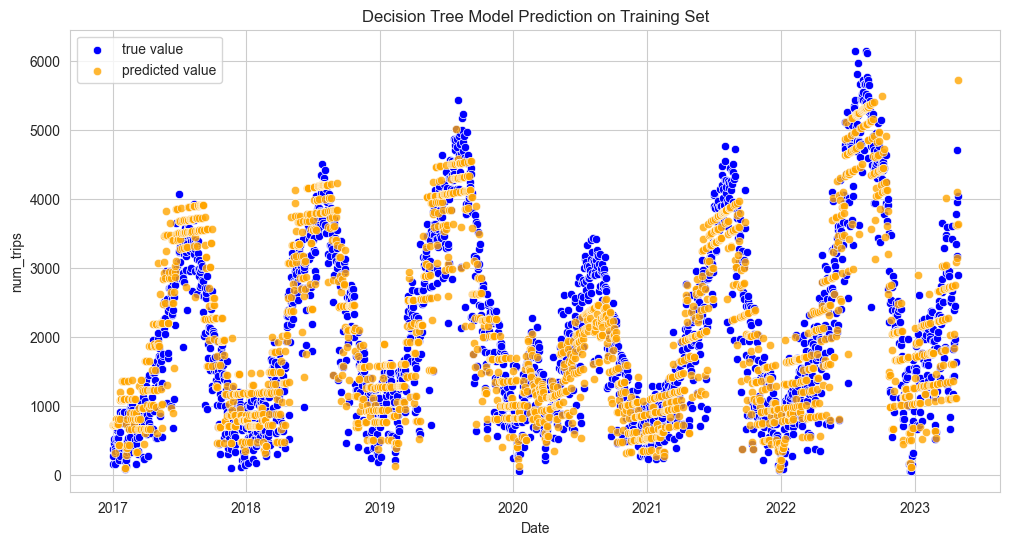

In [26]:
tree = DecisionTreeRegressor(max_depth = 6)
tree.fit(bike_train[['max_temp','total_precip']],bike_train['adj_num_trips'])
pred = tree.predict(bike_train[['max_temp','total_precip']])
fig, ax = plt.subplots(figsize=(12,6))
sns.scatterplot(x=bike_train['Date'], y=bike_train['num_trips'], color='blue', ax=ax, label='true value')
sns.scatterplot(x=bike_train['Date'], y=pred*bike_train['trend'], color='orange', ax=ax, alpha=0.8, label='predicted value')

plt.title('Decision Tree Model Prediction on Training Set')
plt.legend()
plt.show()

We will test this model on the test set.

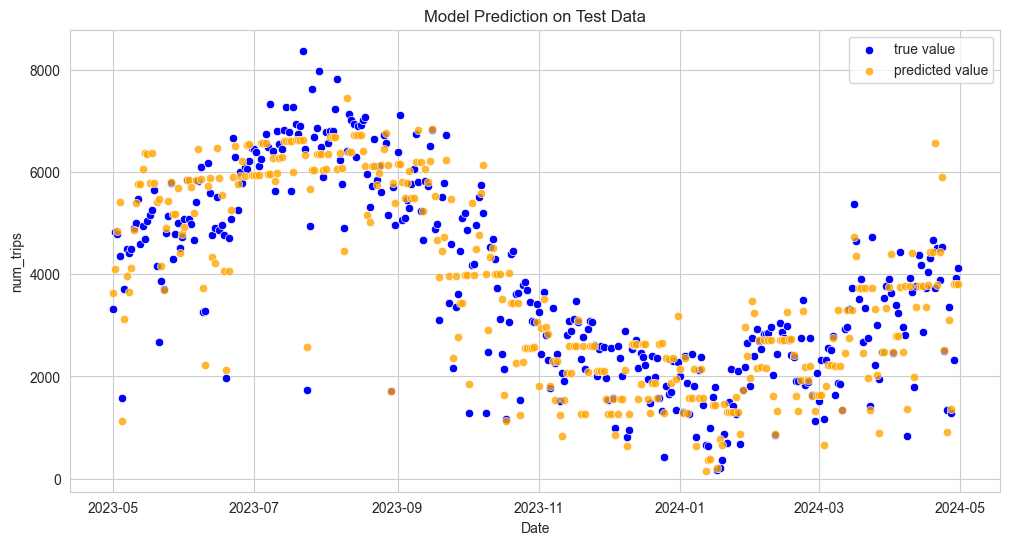

In [27]:
tree = DecisionTreeRegressor(max_depth = 6, random_state = 16)
tree.fit(bike_train[['max_temp', 'total_precip']], bike_train['adj_num_trips'])
pred = tree.predict(bike_test[['max_temp', 'total_precip']])
fig, ax = plt.subplots(figsize=(12,6))
sns.scatterplot(x=bike_test['Date'], y=bike_test['num_trips'], color='blue', ax=ax, label='true value')
sns.scatterplot(x=bike_test['Date'], y=pred*bike_test['trend'], color='orange', ax=ax, alpha=0.8, label='predicted value')

plt.title('Model Prediction on Test Data')
plt.legend()
plt.show()

In [28]:
print('The rmse of the decision tree regressor model on test data is ', np.sqrt(mean_squared_error(bike_test['num_trips'], pred*bike_test['trend'])))

The rmse of the decision tree regressor model on test data is  682.1125587404073


## XGBoost

Now we consider gradient boost based on decision tree regressors.

In [29]:
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [30]:
from xgboost import XGBRegressor

In [31]:
# specify a set of learning rate
rates = [0.01, 0.05, 0.1, 0.3, 0.5]

In [32]:
# specify a set of n_estimators
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]

In [33]:
# specify features
features = ['max_temp', 'total_precip', 'day_length', 'snow_on_ground', 'max_gust']

In [34]:
# initialize the rmse arrays
rmses_xgb_train = np.zeros((5, 2**len(features)-1, len(rates), len(n_estimators)))
rmses_xgb_val = np.zeros((5, 2**len(features)-1, len(rates), len(n_estimators)))

In [35]:
cv_count = 0
for train_index, test_index in kfold.split(bike_train):
    cv_train = bike_train.loc[train_index]
    cv_val = bike_train.loc[test_index]
    feature_count = 0
    for feature in powerset(features):
        feature = list(feature)
        if len(feature)>0:
            print(f'feature_count = {feature_count}, fitting models with {feature}')
            for i, rate in enumerate(rates):
                for j, n in enumerate(n_estimators):
                    xgb_reg = XGBRegressor(learning_rate=rate, max_depth=1, n_estimators=n, random_state=16)
                    xgb_reg.fit(cv_train[feature], cv_train['adj_num_trips'])
                    pred = xgb_reg.predict(cv_val[feature])
                    rmses_xgb_val[cv_count, feature_count, i, j] = np.sqrt(mean_squared_error(pred*cv_val['trend'],cv_val['num_trips']))
            feature_count += 1
    cv_count += 1

feature_count = 0, fitting models with ['max_temp']
feature_count = 1, fitting models with ['total_precip']
feature_count = 2, fitting models with ['day_length']
feature_count = 3, fitting models with ['snow_on_ground']
feature_count = 4, fitting models with ['max_gust']
feature_count = 5, fitting models with ['max_temp', 'total_precip']
feature_count = 6, fitting models with ['max_temp', 'day_length']
feature_count = 7, fitting models with ['max_temp', 'snow_on_ground']
feature_count = 8, fitting models with ['max_temp', 'max_gust']
feature_count = 9, fitting models with ['total_precip', 'day_length']
feature_count = 10, fitting models with ['total_precip', 'snow_on_ground']
feature_count = 11, fitting models with ['total_precip', 'max_gust']
feature_count = 12, fitting models with ['day_length', 'snow_on_ground']
feature_count = 13, fitting models with ['day_length', 'max_gust']
feature_count = 14, fitting models with ['snow_on_ground', 'max_gust']
feature_count = 15, fitting models 

feature_count = 15, fitting models with ['max_temp', 'total_precip', 'day_length']
feature_count = 16, fitting models with ['max_temp', 'total_precip', 'snow_on_ground']
feature_count = 17, fitting models with ['max_temp', 'total_precip', 'max_gust']
feature_count = 18, fitting models with ['max_temp', 'day_length', 'snow_on_ground']
feature_count = 19, fitting models with ['max_temp', 'day_length', 'max_gust']
feature_count = 20, fitting models with ['max_temp', 'snow_on_ground', 'max_gust']
feature_count = 21, fitting models with ['total_precip', 'day_length', 'snow_on_ground']
feature_count = 22, fitting models with ['total_precip', 'day_length', 'max_gust']
feature_count = 23, fitting models with ['total_precip', 'snow_on_ground', 'max_gust']
feature_count = 24, fitting models with ['day_length', 'snow_on_ground', 'max_gust']
feature_count = 25, fitting models with ['max_temp', 'total_precip', 'day_length', 'snow_on_ground']
feature_count = 26, fitting models with ['max_temp', 'tot

In [36]:
# compute the average of rmses
avg_rmses_xgb_val = np.zeros((2**len(features)-1, len(rates), len(n_estimators)))
for k in range(2**len(features)-1):
    for i in range(len(rates)):
        for j in range(len(n_estimators)):
            avg_rmses_xgb_val[k,i,j] = rmses_xgb_val[:,k,i,j].mean()

In [37]:
ind_val_xgb = np.unravel_index(np.argmin(avg_rmses_xgb_val, axis=None), avg_rmses_xgb_val.shape)
print(ind_val_xgb)

(26, 2, 8)


In [38]:
print(f'The minimum validation rmse occurs when features = [max_temp, total_precip, day_length], learning rate = {rates[ind_val_xgb[1]]} and n_estimator = {n_estimators[ind_val_xgb[2]]}')
print('The minimum validation rmse is ', avg_rmses_xgb_val[ind_val_xgb])

The minimum validation rmse occurs when features = [max_temp, total_precip, day_length], learning rate = 0.1 and n_estimator = 200
The minimum validation rmse is  440.18729296797784


Thus, our cross validation shows that the XGBoosting modeled with 'max_temp', 'total_precip', 'day_length' and 'max_gust' yields the minimal validation rmse, which is 440.19 

We will test this model on testing data.

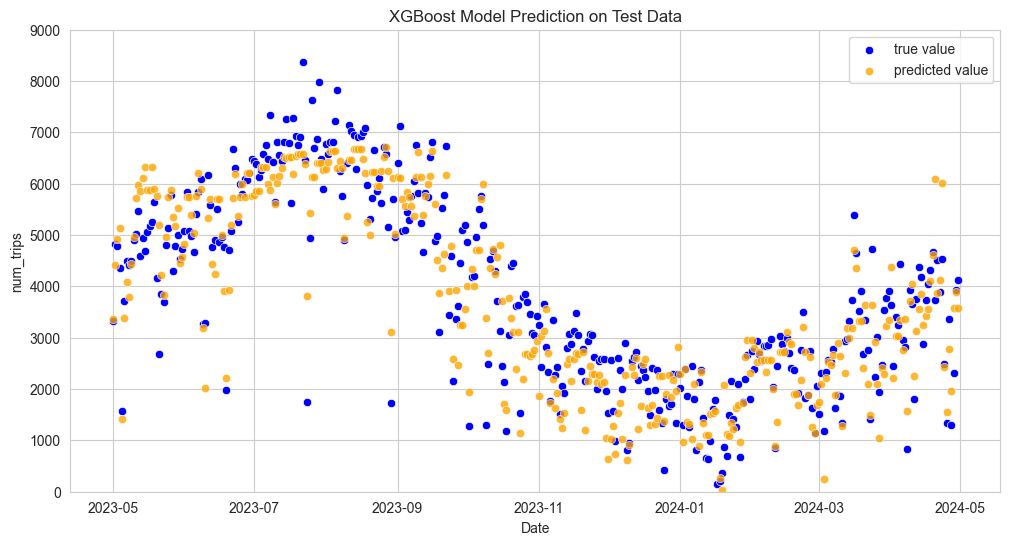

In [41]:
xgb_reg = XGBRegressor(learning_rate=0.1, max_depth=1, n_estimators=200, random_state = 16)
xgb_reg.fit(bike_train[['max_temp', 'total_precip', 'day_length', 'max_gust']], bike_train['adj_num_trips'])
pred = xgb_reg.predict(bike_test[['max_temp', 'total_precip', 'day_length', 'max_gust']])
fig, ax = plt.subplots(figsize=(12,6))
sns.scatterplot(x=bike_test['Date'], y=bike_test['num_trips'], color='blue', ax=ax, label='true value')
sns.scatterplot(x=bike_test['Date'], y=pred*bike_test['trend'], color='orange', ax=ax, alpha=0.8, label='predicted value')
ax.set_ylim(bottom=0, top=9000)
plt.title('XGBoost Model Prediction on Test Data')
plt.legend()
plt.show()

In [42]:
print('The rmse of xgb boost model on test data is ', np.sqrt(mean_squared_error(pred*bike_test['trend'], bike_test['num_trips'])))

The rmse of xgb boost model on test data is  684.7931309970038


In fact, the features 'max_temp' and 'total_precip' seem to be the major influencer to the bike usage. Adding additional features 'max_gust' and 'day_length' only sometimes(depending on random state) yields negligible improvement to the rmse in the prediction of both validation and test data. 
It may be safe to only include 'max_temp' and 'total_precip' in the final model. Reducing the unnecessary data required for prediction could make the model more economical for interested party.